# 神经网络与深度学习实验四————GNN

- 以R8或R52数据集为例，演示使用图注意力神经网络对文档进行分类
- 将每一个文档视作图结点，整个数据集视作图
- 使用词频-逆文档频率（TF-IDF）对文档进行嵌入
- 使用PCA对文档嵌入进行降维（可选）
- 训练GAT和GCN模型对文档进行分类并评估模型

## 一、首先配置环境
------

In [ ]:
!pip install torch
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install torch_geometric

## 二、导入相关模块
------

In [5]:
import pandas as pd
from torch_geometric.data import Data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import numpy as np
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch.nn import LogSoftmax, BatchNorm1d, Dropout, Module
import torch.optim as optim

import matplotlib.pyplot as plt

## 三、读取r8数据集
------

In [6]:
%%time
df = pd.read_csv('datasets/r8/r8.csv')

texts = df['text'].tolist()  # R8数据集的文本列表
labels = df['intent'].tolist()  # R8数据集的标签列表
labels2idx = {intent: idx for idx, intent in enumerate(df['intent'].unique().tolist())}

CPU times: user 35.9 ms, sys: 4.41 ms, total: 40.3 ms
Wall time: 39.2 ms


## 四、计算TF-IDF 词频-逆文档频率， 对文档进行嵌入
------

In [7]:
%%time
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

# 计算文档间的余弦相似度， 超过0.7阈值就构建一条边
cosine_sim = cosine_similarity(tfidf_matrix)

edge_index = []
for i in range(len(texts)):
    for j in range(len(texts)):
        if i != j and cosine_sim[i, j] > 0.9:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

tfidf_features = tfidf_matrix.toarray()

CPU times: user 16.6 s, sys: 519 ms, total: 17.1 s
Wall time: 17.1 s


## 五、可视化图结构 (可选)
#### 图过于复杂可视化效果不好而且渲染时间非常长, 建议不要运行
------

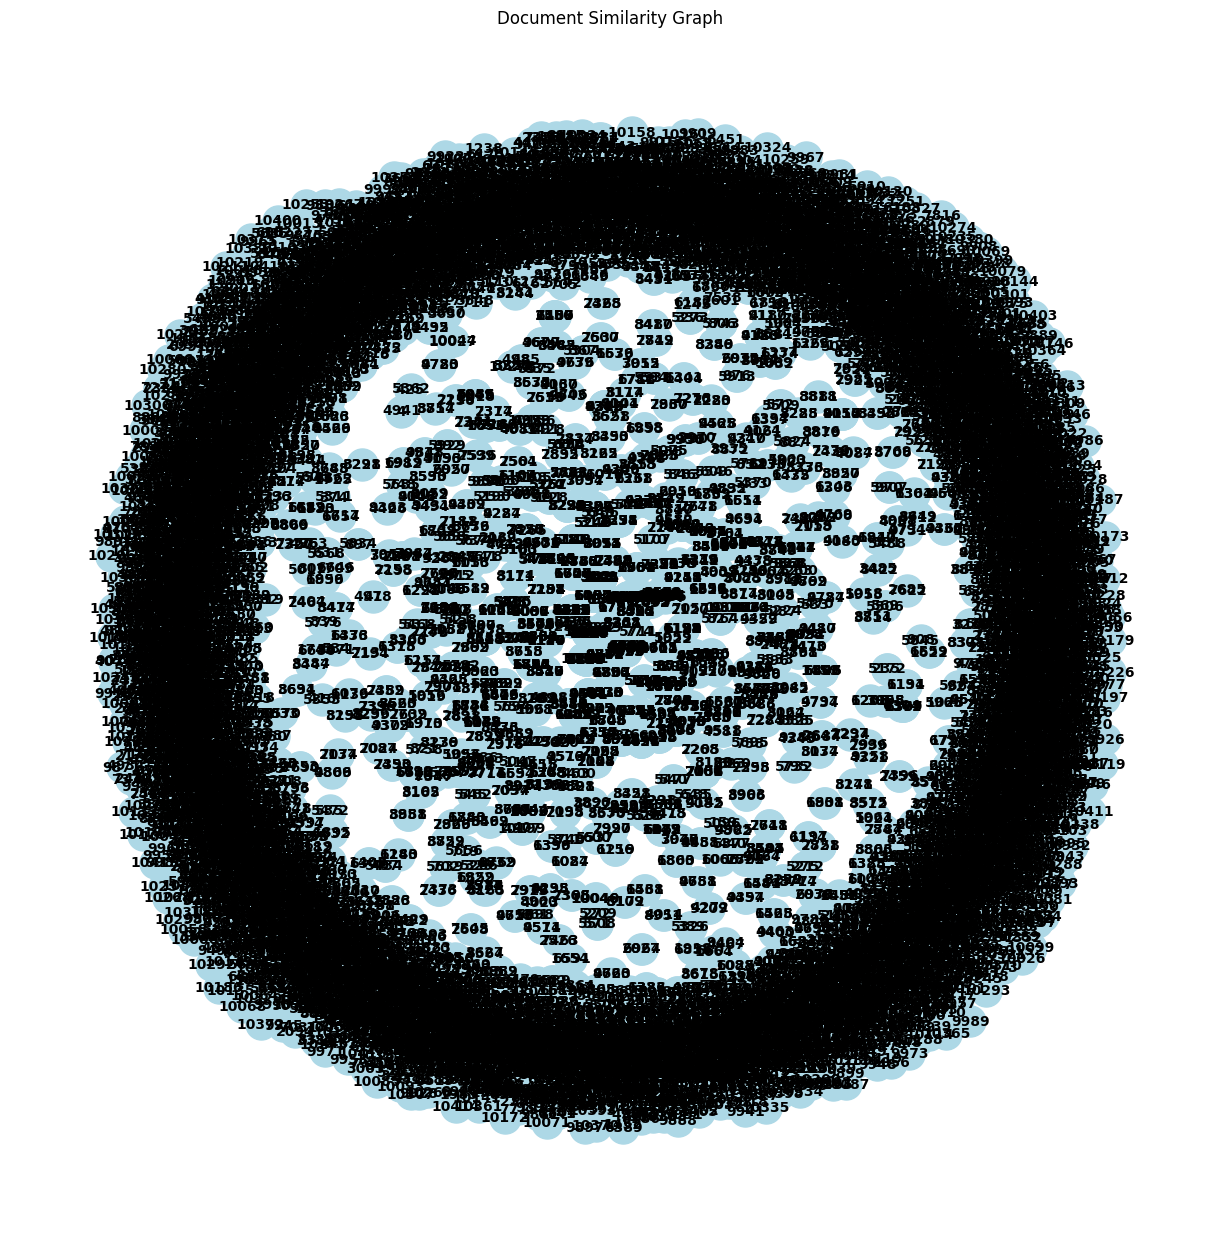

In [8]:
# G = nx.Graph()
# G.add_nodes_from(range(len(texts)))
# for i, j in edge_index.t().numpy():
#     G.add_edge(i, j)
#     
# plt.figure(figsize=(12, 12))
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
# plt.title("Document Similarity Graph")
# plt.show()

## 六、进行特征降维 (可选)
#### 原始文档的特征维度等同于词汇表大小，这在大型数据集上是很大的，需要进行降维才能进一步处理，不过降维同时也需要很多时间，对于这个数据集不降维也可以
------

In [9]:
%%time
# 使用PCA对特征进行降维，减小计算量
n_components = 500
print(f"降维前{tfidf_features.shape[1]}->降维后{n_components}")
pca = PCA(n_components=n_components)
tfidf_features = pca.fit_transform(tfidf_features)

降维前14575->降维后500
CPU times: user 5min 53s, sys: 4min 29s, total: 10min 22s
Wall time: 28.1 s


## 七、构建torch_geometric图数据
------

In [10]:
# 转换为PyTorch张量
x = torch.FloatTensor(tfidf_features)
y = torch.LongTensor([labels2idx[label] for label in labels])

# 创建PyTorch Geometric图数据
data = Data(x=x, edge_index=edge_index, y=y)

# 假设data是PyTorch Geometric的图数据，包含特征x和标签y
# 假设num_nodes是图中节点的总数
num_nodes = data.num_nodes

# 创建掩码
indices = np.random.permutation(num_nodes)
train_size = int(num_nodes * 0.8)  # 例如，80%的节点用于训练
print(f"num nodes: {num_nodes}, train size: {train_size}, val size: {num_nodes - train_size}")
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask

num nodes: 10421, train size: 8336, val size: 2085


## 八、构建模型
#### 提供了GAT模型和GCN模型，API均保持一致，可以在后面尝试使用不同的模型
------
GAT与GCN的比较：
- GAT: 使用注意力机制来赋予不同邻居不同的重要性。这使得GAT能够更加灵活地捕捉节点间的复杂关系。计算更为复杂，处理不规则图上更具适应性。
- GCN: 没有注意力机制。它使用简化的卷积操作，其中所有邻居对中心节点的贡献均等。计算相较简单，适合处理规则图。

In [21]:
class GAT(Module):
    name = 'GAT'
    def __init__(self, in_feats, hidden_feats, out_feats, drop, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, hidden_feats, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_feats * num_heads, out_feats, heads=1, concat=False)
        self.dropout = Dropout(drop)
        self.bn1 = BatchNorm1d(hidden_feats * num_heads)
        self.logsoftmax = LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.view(-1, self.conv1.heads * self.conv1.out_channels)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.logsoftmax(x)
        return x
    

class GCN(Module):
    name = "GCN"
    def __init__(self, in_feats, hidden_feats, out_feats, drop):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)
        self.dropout = Dropout(drop)
        self.logsoftmax = LogSoftmax(dim=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.logsoftmax(x)
        return x


## 九、进行模型训练
------

In [25]:
%%time
NUM_CLASSES = 8
NUM_EPOCHS = 100
LR = 0.005

# 创建模型实例
# model = GCN(in_feats=data.x.shape[1], hidden_feats=64, out_feats=NUM_CLASSES, drop=0.6)
model = GAT(in_feats=data.x.shape[1], hidden_feats=64, out_feats=NUM_CLASSES, drop=0.6)
optimizer = optim.Adam(model.parameters(), lr=LR)


# 训练函数
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


# 验证函数
def validate():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = pred[data.val_mask] == data.y[data.val_mask]
        acc = int(correct.sum()) / int(data.val_mask.sum())
    return acc

losses, val_accuracies = [], []
# 训练循环
for epoch in range(NUM_EPOCHS):
    loss = train()
    val_acc = validate()
    losses.append(loss)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')
    
# 保存模型
torch.save(model.state_dict(), f'model_{model.name}_state_dict.pt')


Epoch: 0, Loss: 3.0888, Val Acc: 0.7842
Epoch: 1, Loss: 1.3353, Val Acc: 0.8638
Epoch: 2, Loss: 0.5096, Val Acc: 0.8882
Epoch: 3, Loss: 0.2225, Val Acc: 0.8945
Epoch: 4, Loss: 0.1367, Val Acc: 0.9055
Epoch: 5, Loss: 0.0908, Val Acc: 0.9079
Epoch: 6, Loss: 0.0662, Val Acc: 0.9098
Epoch: 7, Loss: 0.0557, Val Acc: 0.9103
Epoch: 8, Loss: 0.0443, Val Acc: 0.9146
Epoch: 9, Loss: 0.0371, Val Acc: 0.9199
Epoch: 10, Loss: 0.0337, Val Acc: 0.9228
Epoch: 11, Loss: 0.0313, Val Acc: 0.9295
Epoch: 12, Loss: 0.0245, Val Acc: 0.9348
Epoch: 13, Loss: 0.0229, Val Acc: 0.9405
Epoch: 14, Loss: 0.0190, Val Acc: 0.9453
Epoch: 15, Loss: 0.0170, Val Acc: 0.9492
Epoch: 16, Loss: 0.0172, Val Acc: 0.9554
Epoch: 17, Loss: 0.0148, Val Acc: 0.9607
Epoch: 18, Loss: 0.0132, Val Acc: 0.9645
Epoch: 19, Loss: 0.0128, Val Acc: 0.9655
Epoch: 20, Loss: 0.0118, Val Acc: 0.9683
Epoch: 21, Loss: 0.0108, Val Acc: 0.9717
Epoch: 22, Loss: 0.0111, Val Acc: 0.9746
Epoch: 23, Loss: 0.0112, Val Acc: 0.9765
Epoch: 24, Loss: 0.0135, V

## 十、实验结果分析
------

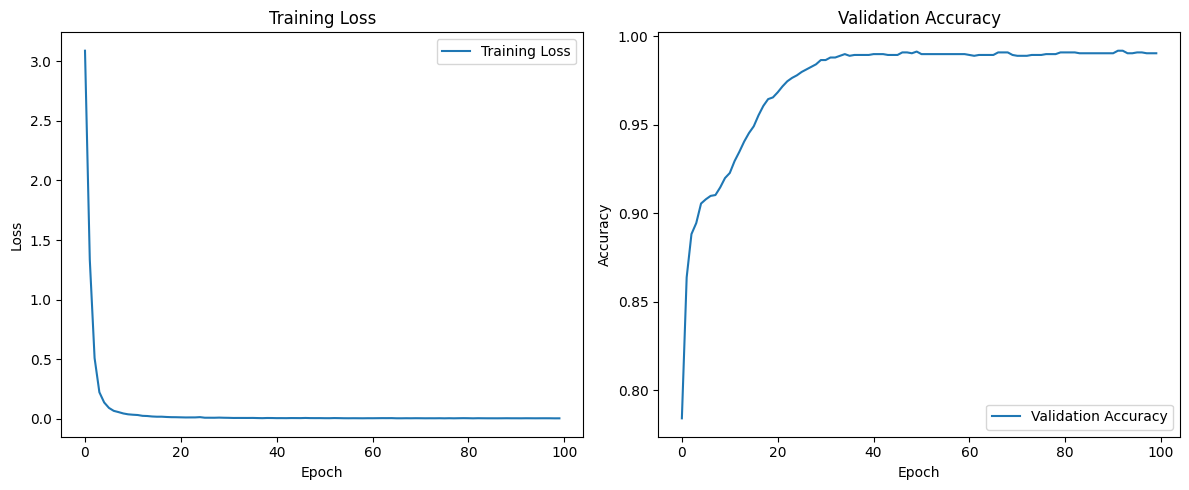

In [26]:
plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制验证准确率
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### created by 2021213368张瀚墨, 2023/11/27

In [17]:
print('the end...')

the end...
